# CO$_2$ Atmosphere Concentration

![Global Warming](img/co2.jpeg)

This work is related carbon dioxide concentration on the atmosphere and the temperature evolution throughout the years in the world.

In this part of the analysis, it is going to be presented the CO2 concentration analysis and as showcase.

It is presented in the following sections:

1. Data Loading
2. Data Exploratory
3. Summary statistics
4. Modelling Time Series (ARIMA)
5. Conclusion

In [67]:
############# Setting up Env #############
## RUN THIS CELL ONLY IF YOU DO NOT HAVE## 
## YOUR DEVELOPMENT ENVIRONMENT SET UP  ##
############# Setting up Env #############

# Uncomment the lines below
# import sys
# !{sys.executable} -m pip install -r requirements.txt

In [67]:
import numpy as np 
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Data Loading

The dataset in this analysis can be found in the link below:

[CO$_2$ Concentration Dataset](https://bit.ly/32zAB7A)

This dataset can also be found in the folder [data](/data).

In [68]:
co2 = pd.read_csv('data/mole_fraction_of_carbon_dioxide.csv')

In [69]:
co2.head()

,datenum,year,month,day,datetime,data_mean_global,data_mean_nh,data_mean_sh
0,15,0,1,15,15-Jan-0000 00:00:00,278.366439,279.045659,277.687219
1,46,0,2,15,15-Feb-0000 00:00:00,278.713058,279.665398,277.760718
2,75,0,3,15,15-Mar-0000 00:00:00,279.013835,280.266779,277.760892
3,106,0,4,15,15-Apr-0000 00:00:00,279.209613,280.756607,277.662620
4,136,0,5,15,15-May-0000 00:00:00,279.106444,280.613494,277.599394


To keep this analysis consitent with the temperature forecast perfomed in the other notebook, we are going to analyse the dataset from 1900.

In [70]:
YEAR_START = 1900
df2 = co2[co2.year >= YEAR_START]

In [71]:
df2.head()

,datenum,year,month,day,datetime,data_mean_global,data_mean_nh,data_mean_sh
22800,693976,1900,1,15,15-Jan-1900 00:00:00,296.205964,297.023130,295.388798
22801,694007,1900,2,15,15-Feb-1900 00:00:00,296.614810,297.706181,295.523438
22802,694035,1900,3,15,15-Mar-1900 00:00:00,296.980286,298.371424,295.589149
22803,694066,1900,4,15,15-Apr-1900 00:00:00,297.243354,298.924514,295.562195
22804,694096,1900,5,15,15-May-1900 00:00:00,297.204653,298.835449,295.573858


In [72]:
df2.index = (df2.year.astype(str).apply(lambda x: x.zfill(4)) + 
    "-" + 
   df2.month.astype(str).apply(lambda x: x.zfill(2)) +
    "-01"
)
df2.index = pd.to_datetime(df2.index)
df2 = df2.drop(['datenum', 'datetime', 'day'], axis=1)
df2.head()

,year,month,data_mean_global,data_mean_nh,data_mean_sh
1900-01-01,1900,1,296.205964,297.023130,295.388798
1900-02-01,1900,2,296.614810,297.706181,295.523438
1900-03-01,1900,3,296.980286,298.371424,295.589149
1900-04-01,1900,4,297.243354,298.924514,295.562195
1900-05-01,1900,5,297.204653,298.835449,295.573858


In [73]:
df2 = df2[:'2013-09-01 00:00:00']

## Data Exploratory

An exploration in the data is perfomed below. There will be a yealy and monthly charts to understand seasonality and the curves shapes.

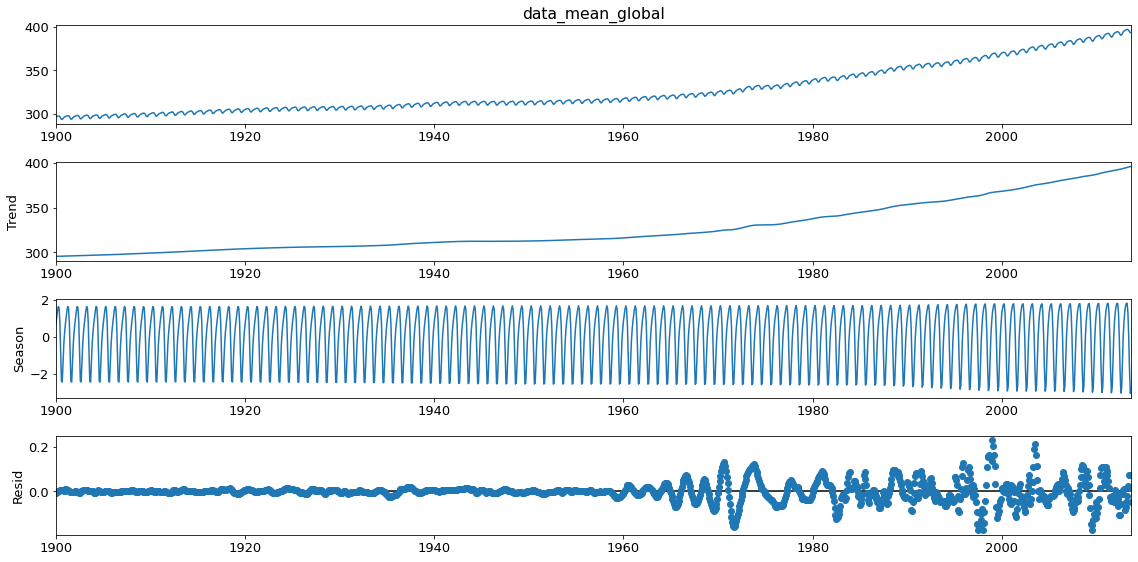

In [74]:
# Using the STL (Season, Trend and Low-pass) to decompose the serie and have a nice view of trend and seasonality
plt.rc('figure',figsize=(16,8))
plt.rc('font',size=13)
stl = STL(df2.data_mean_global, seasonal=13)
res = stl.fit()
fig = res.plot()

The CO$_2$ concentration is almost constant since the start of the series and then from the 1950's there is an inflexion point where it can be seen the increase in the serie itself but also in the trend. 

On the other hand, there are an expressive resid when the CO$_2$ concentration starts to increase. The explanation for this is the [increase in the burning of fossil fuels](https://www.noaa.gov/stories/carbon-dioxide-levels-race-past-troubling-milestone) — coal to make electricity and steel, oil for vehicles and manufacturing — vastly accelerated the rate of CO2 being pumped into the atmosphere.

## Summary Statistics

This is an important part of the analysis. Given the data exploratory where we could check the behavior important facts such as the increase in the burning of fossil fuels.

Again, an Adfuller test is going to be our best tool to determine if the series is stationary or not. If not, a transformation is going to be needed.

In [75]:
# Splitting the dataset into train, validation and test to perform walk forward and back test

train_set = df2[:-5*12]
val_set   = df2[-5*12:-1*12]
test_set  = df2[-1*12:]

In [77]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1305 entries, 1900-01-01 to 2008-09-01
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              1305 non-null   int64  
 1   month             1305 non-null   int64  
 2   data_mean_global  1305 non-null   float64
 3   data_mean_nh      1305 non-null   float64
 4   data_mean_sh      1305 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 61.2 KB


In [79]:
val_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2008-10-01 to 2012-09-01
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              48 non-null     int64  
 1   month             48 non-null     int64  
 2   data_mean_global  48 non-null     float64
 3   data_mean_nh      48 non-null     float64
 4   data_mean_sh      48 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 2.2 KB


In [80]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2012-10-01 to 2013-09-01
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              12 non-null     int64  
 1   month             12 non-null     int64  
 2   data_mean_global  12 non-null     float64
 3   data_mean_nh      12 non-null     float64
 4   data_mean_sh      12 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 576.0 bytes


In [101]:
def adfuller_test(X):
    # Applying Adfuller test to indentify stationarity in the serie
    # Source: https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
    adfuller_resp2 = adfuller(X)

    adfuller_analysis2 = pd.Series(adfuller_resp2[0:4], 
                                  index=['ADF Statistic','p-value','Lags','# Observations'])
    adfuller_analysis2 = round(adfuller_analysis2,5)

    for key, value in adfuller_resp2[4].items():
            adfuller_analysis2["Critical Value (%s)"%key] = value.round(5)

    if adfuller_analysis2[0] < adfuller_analysis2[5]:
        print('The presented series seems stationary.\n')
    else:
        print('The series seems to be non-stationary.\n')
    print(adfuller_analysis2)

In [102]:
adfuller_test(X=train_set.data_mean_global)

The series seems to be non-stationary.

ADF Statistic              3.93942
p-value                    1.00000
Lags                      23.00000
# Observations          1281.00000
Critical Value (1%)       -3.43547
Critical Value (5%)       -2.86380
Critical Value (10%)      -2.56797
dtype: float64


As seem above, the series is non-stationary and we will transform the data using the difference from $Y_t$ and $Y_{tn}$ so we can induce stationarity in the series.

In [213]:
# Auxiliar functions
def difference(df, interval=1):
    diff_= []
    for i in range(interval, len(df)):
        value = df[i] - df[i - interval]
        diff_.append(value)
    return np.array(diff_)

def inverse_diff(diff, y_pred, interval=1):
    return y_pred + diff[-interval]

def MAE(y, y_pred):
    return mean_absolute_error(y, y_pred)

def plot_series(y, y_pred, title='Plot Results', y_label='Y', x_label='X'):
    # Plot configs
    plt.figure(figsize=(20,8))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(y.index, y.values)
    plt.plot(y.index, y_pred, color='red')
    # Legend handling
    red_patch = mpatches.Patch(color='red', label='Predicted Concentration')
    blue_patch = mpatches.Patch(color='blue', label='Real Concentration')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

In [202]:
X = train_set.data_mean_global
interval = 2
diff_train = difference(df=X, interval=interval)

In [203]:
adfuller_test(X=diff_train)

The presented series seems stationary.

ADF Statistic             -2.87918
p-value                    0.04782
Lags                      23.00000
# Observations          1279.00000
Critical Value (1%)       -3.43547
Critical Value (5%)       -2.86380
Critical Value (10%)      -2.56797
dtype: float64


After using an interval of $2$, we can observe that now the differentiated series is stationary by Adfuller test.

## Modelling

The modelling is structured in three big parts:

1. Baseline model using Moving Average
2. ARIMA model

The ARIMA model in this CO$_2$ concentration problem is going to use an static forecasting approach where we use the training at $Y_{t-1}$ to predict the $Y_t$, $Y_{t+1}$, $...$, $Y_{t+k}$ values. 

We also use the [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) as a metric in this scenario.

In [211]:
# Creating a baseline model we want to start with
WINDOW=3
baseline = val_set.data_mean_global.rolling(WINDOW).mean()
baseline.dropna(inplace=True)

In [212]:
# Evaluating the Mean Absolute Error of the baseline model
mae_baseline = MAE(val_set.iloc[WINDOW-1:,0],baseline)
print(f'The MAE of the baseline is {round(mae_baseline,4)} Co2 concentration')

The MAE of the baseline is 1621.0747 Co2 concentration


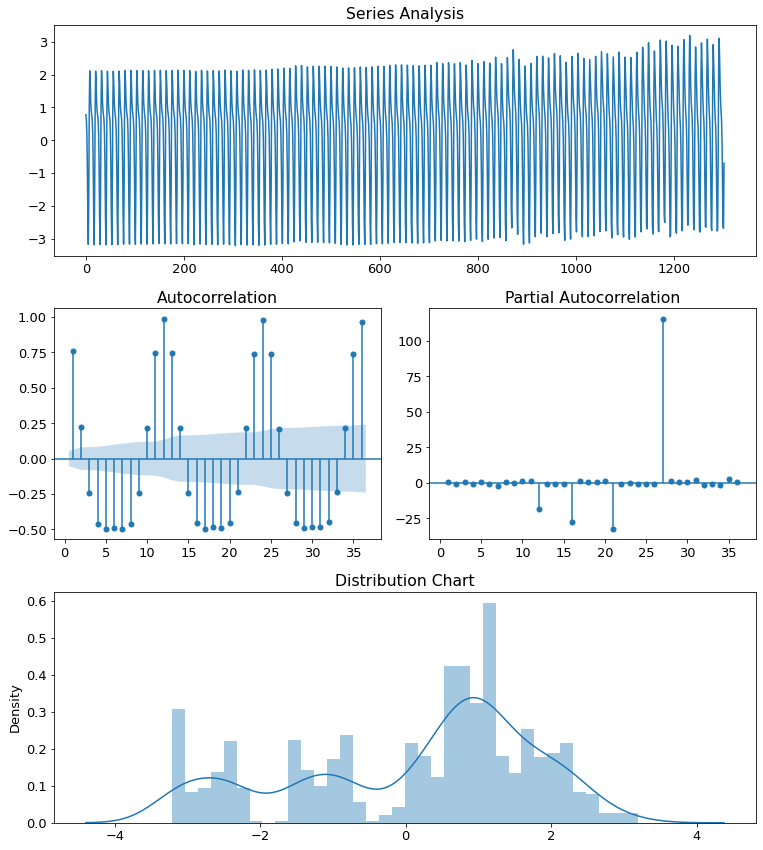

In [204]:
#Same results and the series is stationary

# After identifying that the series is stationary, let's understand the ARIMA model parameters
lags_plots = 36
figsize=(16,12)

# Creating plots of the DF
y = pd.Series(diff_train)
fig = plt.figure()

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 3), (1, 0))
ax3 = plt.subplot2grid((3, 3), (1, 1))
ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

y.plot(ax=ax1, figsize=figsize)
ax1.set_title('Series Analysis')
plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
ax4.set_title('Distribution Chart')

plt.tight_layout()

In [207]:
model = ARIMA(diff_train, order=(3,0,1)).fit(disp=0)
initial_idx = len(train_set.index)
final_idx   = initial_idx + 12
forecast = model.predict(start=initial_idx, end=final_idx)

In [208]:
history = [x for x in X]
inverted_forecast = []
idx=0
real=[]
for yhat in forecast:
    inverted = inverse_diff(history, yhat, interval)
    print('Prediction/Real for: %s- %f' % (str(val_set.index[idx])[:11], inverted) + ' / '+ str(val_set.data_mean_global[val_set.index == val_set.index[idx]].values[0]))
    history.append(inverted)
    inverted_forecast.append(inverted)
    real.append(val_set.data_mean_global[val_set.index == val_set.index[idx]].values[0])
    idx += 1

Prediction/Real for: 2008-10-01 - 383.959822 / 384.051818590828
Prediction/Real for: 2008-11-01 - 385.352680 / 385.46240866112
Prediction/Real for: 2008-12-01 - 385.831783 / 386.349028234684
Prediction/Real for: 2009-01-01 - 385.425206 / 387.085162397516
Prediction/Real for: 2009-02-01 - 384.709828 / 387.447115897967
Prediction/Real for: 2009-03-01 - 384.355647 / 387.67375907852204
Prediction/Real for: 2009-04-01 - 384.548795 / 387.757257781782
Prediction/Real for: 2009-05-01 - 385.083017 / 387.322994620408
Prediction/Real for: 2009-06-01 - 385.522850 / 386.09242862055197
Prediction/Real for: 2009-07-01 - 385.658779 / 384.428547518294
Prediction/Real for: 2009-08-01 - 385.504878 / 383.342018240952
Prediction/Real for: 2009-09-01 - 385.317328 / 383.79651939578696
Prediction/Real for: 2009-10-01 - 385.262171 / 385.440695945999
Prediction/Real for: 2009-11-01 - 385.412136 / 386.976942307698
Prediction/Real for: 2009-12-01 - 385.632827 / 387.99678672169


In [209]:
plot_series

The MAE of the ARIMA model is 385.6528 CO2 concentration


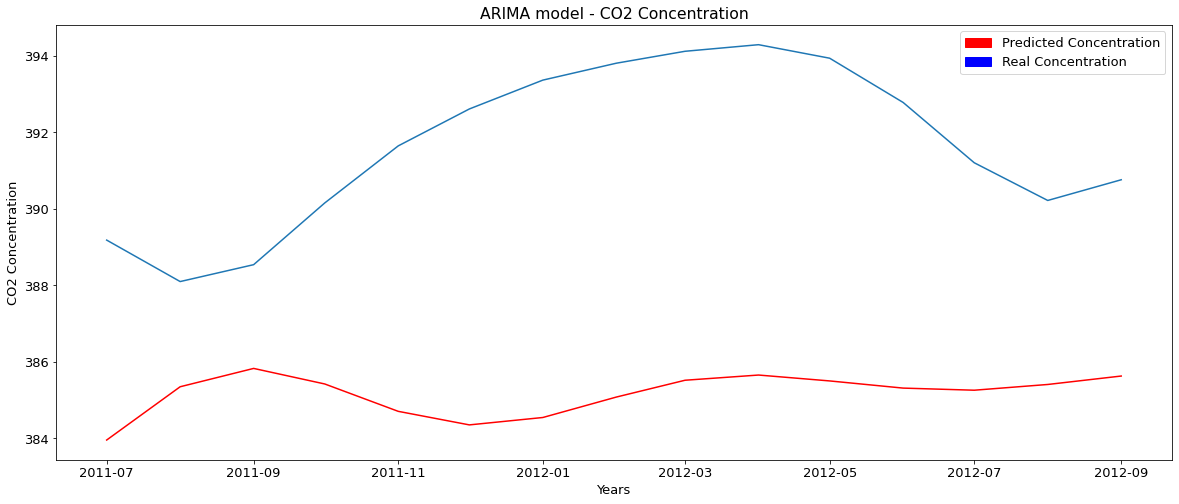

In [214]:
plot_series(y=val_set.data_mean_global[-15:], y_pred=inverted_forecast, title='ARIMA model - CO2 Concentration', 
            x_label='Years', y_label='CO2 Concentration')

The predictions for the ARIMA model is better than the baseline, but the error is still high. Looking at the curve above, it can be seen an difference between the true values and the predicted ones. It can due to the non-stationarity of the data. Even thogh, we have a good approximation of the real curve that can be better explored with more sofisticated models.

## Conclusion

In this notebook it was developed an analysis of the $CO_2$ concentration in the world. This concentration is increasing and in the last century we there was a dramatic increase in the consumption of the fossil fuels which lead us to the increase in the curve.

The models developed uses [ARIMA](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html) as an autoregressive model to capture not only the seasonality but also the moving average.

The results satisfactory given the complexity of the topic. For further analysis, it is important explore Deep Learning models such as [LSTM for time series](https://www.tensorflow.org/tutorials/structured_data/time_series) or other statistical models that would fit better in the data as said in the temperature analysis.